In [1]:
import numpy.matlib
import numpy as np
import matplotlib.pyplot as plt
# import os
import scipy.io as scio

In [2]:
matfile = scio.loadmat("../MATLAB/ADNI.mat")
ADNI = matfile["ADNI"]

In [3]:
def BOLD(rate, period, step):
    l = period
    h = step
    f = flow(rate, period, step)
    
    tau = 2
    a = 0.4
    E0 = 0.6

    k1 = 7 * E0
    k2 = 2 * E0
    k3 = 2 * E0 - 0.2
    V = 0.2
    v = np.ones(rate.shape)
    q = np.ones(rate.shape)

    for k in range(1, int(l/h)):
        # kinetics equations
        v_dot = 1/tau * (f[:, k, None] - v[:, k, None] ** (1/a))
        q_dot = 1/tau * (f[:, k, None] * (1 - (1 - E0) ** (1 / f[:, k, None])) / E0 - v[:, k, None] ** (1/a - 1) * q[:, k, None])
        # integrator
        v[:, k + 1, None] = v[:, k, None] + h * v_dot
        q[:, k + 1, None] = q[:, k, None] + h * q_dot

    return V * (k1 * (1 - q) + k2 * (1 - q / v) + k3 * (1 - v))

def flow(rate, period, step):
    kappa = 1 / 1.54
    gamma = 1 / 1.44
    p = rate
    h = step
    l = period
    f = np.ones(p.shape)
    q = np.zeros(p.shape)
    
    for k in range(1, int(l/h)):
        # kinetics equations
        dq = p[:, k, None] - kappa * q[:, k, None] + gamma * (1 - f[:, k, None])
        df = q[:, k, None]
        # integrator
        q[:, k + 1, None] = q[:, k, None] + h * dq
        f[:, k + 1, None] = f[:, k, None] + h * df
    
    return f


# nice para. ei=-0.21;i=-0.01;ie=0.08
nice para.

$c_e=16; c_ei=25; c_i=3; c_ie=39; \tau=8; G=5; I_{ext}=1$

$c_e=16; c_ei=25; c_i=3; c_ie=39; \tau=120; G=5; I_{ext}=1$

$c_e=16; c_ei=25; c_i=3; c_ie=39; \tau=8; G=5; I_{ext}=0.7$

funny para.

$c_e=16; c_ei=25; c_i=3; c_ie=39; \tau=8; G=5; I_{ext}=1.25$


In [4]:
def Wilson_Cowan(connectome, period, step, a, G):
    h = step
    t = np.arange(0., period, h)
    C = connectome
    c_e = 16.
    c_ei = 25.
    c_i = 3.
    c_ie = 39.
    taue = 8.
    taui = 12.
    Iext = 1.
    
    s = np.shape(connectome)[1]
    E = np.zeros([s, int(period/step) + 1])
    I = np.zeros([s, int(period/step) + 1])
    E[:, 0, None] = 0.5*np.random.rand(s, 1)
    I[:, 0, None] = 0.5*np.random.rand(s, 1)
    dE = np.zeros([s, int(period/step) + 1])
    dI = np.zeros([s, int(period/step) + 1])
    fE = np.zeros([s, int(period/step) + 1])
    fI = np.zeros([s, int(period/step) + 1])
    
    # n = 0.7
    w = 1e-5
    
    for k in range(int(period/step)):
        e = E[:, k, None]
        i = I[:, k, None]
        fe = Fe(c_e * e + G * C @ e - c_ei * i + Iext)# + w * np.random.normal(0, 1, [s, 1]))
        fi = Fi(c_ie * e - c_i * i)# + w * np.random.normal(0, 1, [s, 1]))
        
        # mE = np.max(fE)
        # mI = np.max(fI)
        mE = 1
        mI = 1
        # print(mE)
        # print(mI)

        # de = - 1/tau * (e + (mE - e) * fE) + np.random.poisson(a, [s, 1])
        # di = - 1/tau * (i + (mI - i) * fI) + np.random.poisson(a, [s, 1])
        # de = 1/tau * (-e + (mE - e) / mE * fE) + n * np.random.poisson(a, [s, 1])
        # di = 1/tau * (-i + (mI - i) / mI * fI) + n * np.random.poisson(a, [s, 1])
        de = 1/taue * (-e + (mE - e) * fe)
        di = 1/taui * (-i + (mI - i) * fi)
        # print(dE.shape)
        E[:, k + 1, None] = e + de * h + w * np.random.normal(0, 1, [s, 1])
        I[:, k + 1, None] = i + di * h + w * np.random.normal(0, 1, [s, 1])
        dE[:, k + 1, None] = de
        dI[:, k + 1, None] = di
        fE[:, k + 1, None] = fe
        fI[:, k + 1, None] = fi
        # np.append(dE, de)
        # np.append(dI, di)
    return [E, I, dE, dI, fE, fI]

def Fe(x):
    a = 1.3
    theta = 2.1
    return 1 / (1 + np.exp(1 + a * (theta - x))) - 1 / (1 + np.exp(1 + a * theta))

def Fi(x):
    a = 2.
    theta = 3.7
    return 1 / (1 + np.exp(1 + a * (theta - np.array(x)))) - 1 / (1 + np.exp(1 + a * theta))

In [5]:
period = 10000.
step = 0.1
num = 1
begin = 1000
result = Wilson_Cowan(ADNI[num], period, step, a=0.001, G=5)
bold = BOLD(result[0], period, step)
time = np.arange(0, period + step, step)


Text(0.5, 1.0, 'ADNI_expSC')

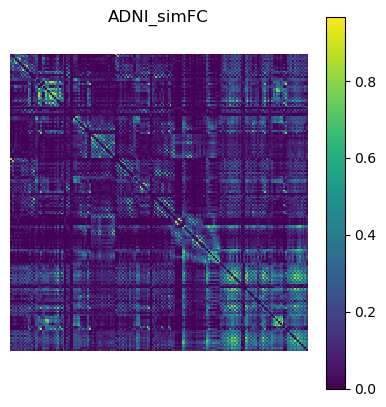

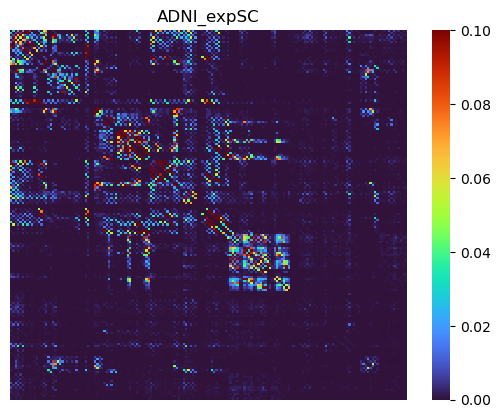

In [6]:
fC = np.corrcoef(result[0][:, int(begin/step):])
for i in range(fC.shape[0]):
    fC[i, i] = 0
# plt.figure()

# np.savetxt("ADIN_FC",fC)
import seaborn as sns
plt.matshow(fC*(fC>0))
# sns.heatmap(fC, vmin=0, vmax=1, cmap="turbo")
plt.title("ADNI_simFC")
plt.axis("off")
plt.colorbar()
plt.savefig("adni.png", bbox_inches="tight")
# plt.matshow(fC)


plt.figure()
# plt.matshow(ADNI[0], cmap="jet")
sns.heatmap(ADNI[num], vmin=0, vmax=0.1, cmap="turbo")
plt.axis("off")
# plt.matshow()
plt.title("ADNI_expSC")
# plt.colorbar("off")



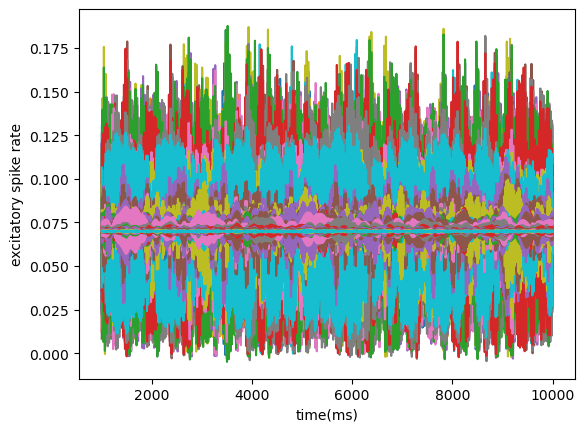

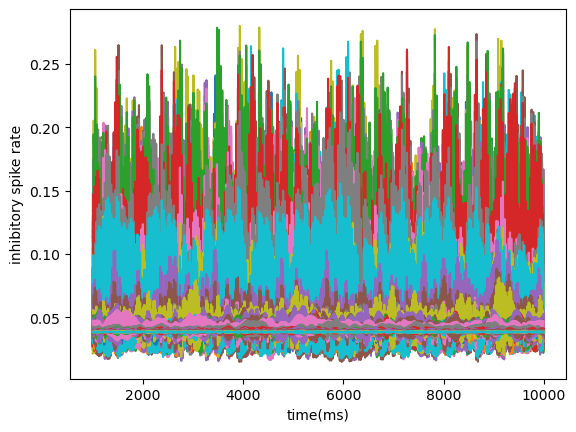

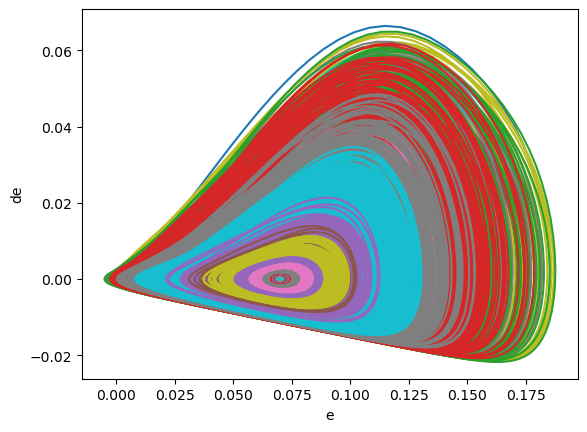

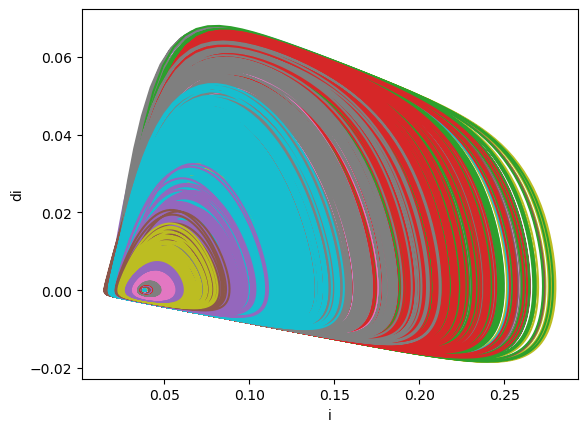

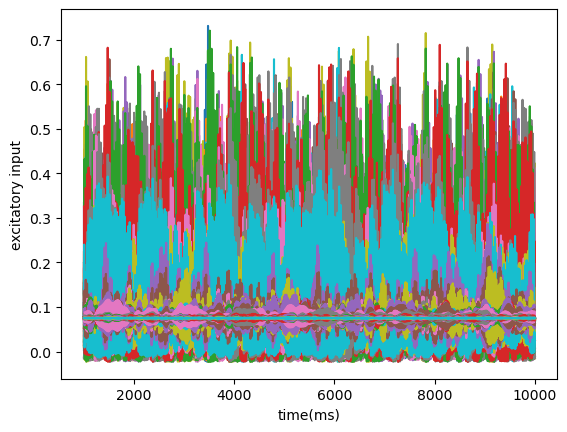

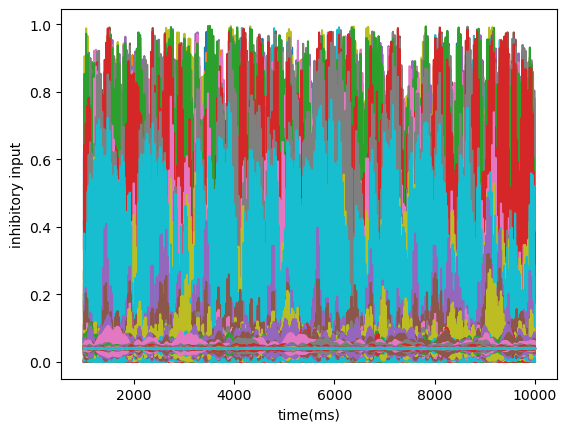

In [ ]:
for i in range(ADNI[0].shape[0]):
    plt.figure(1)
    plt.plot(time[int(begin/step):], result[0][i, int(begin/step):])
    plt.xlabel("time(ms)")
    plt.ylabel("excitatory spike rate")
    plt.figure(2)
    plt.xlabel("time(ms)")
    plt.ylabel("inhibitory spike rate")
    plt.plot(time[int(begin/step):], result[1][i, int(begin/step):])
    plt.figure(4)
    plt.xlabel("e")
    plt.ylabel("de")
    plt.plot(result[0][i, int(begin/step):], result[2][i, int(begin/step):])
    plt.figure(5)
    plt.xlabel("i")
    plt.ylabel("di")
    plt.plot(result[1][i, int(begin/step):], result[3][i, int(begin/step):])
    plt.figure(6)
    plt.xlabel("time(ms)")
    plt.ylabel("excitatory input")
    plt.plot(time[int(begin/step):], result[4][i, int(begin/step):])
    plt.figure(7)
    plt.xlabel("time(ms)")
    plt.ylabel("inhibitory input")
    plt.plot(time[int(begin/step):], result[5][i, int(begin/step):])
# plt.figure(3)
# plt.xlabel("excitatory spike rate")
# plt.ylabel("inhibitory spkie rate")
# plt.plot(result[0][num, int(begin/step):], result[1][num, int(begin/step):])


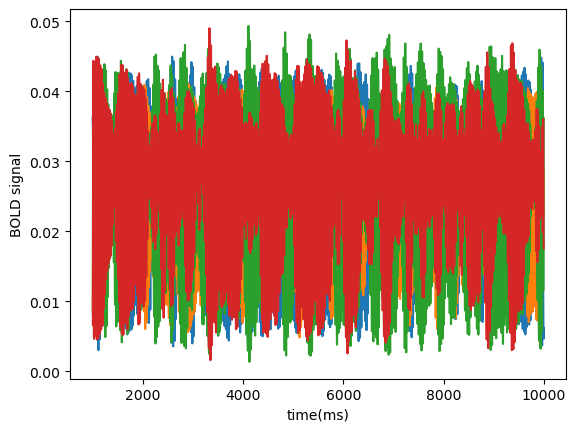

In [17]:
for i in range(ADNI.shape[0]):
    plt.plot(time[int(begin/step):], bold[i, int(begin/step):])
    plt.xlabel("time(ms)")
    plt.ylabel("BOLD signal")

In [ ]:
for i in range(ADNI.shape[0]):
    s = np.std(bold[i, int(begin/step):])
    if not s:
        print(i),

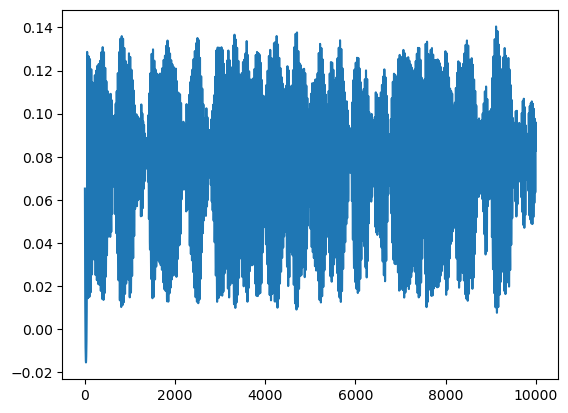

In [ ]:
plt.plot(time ,result[0][0, :, None])

5.656083495078529e-10


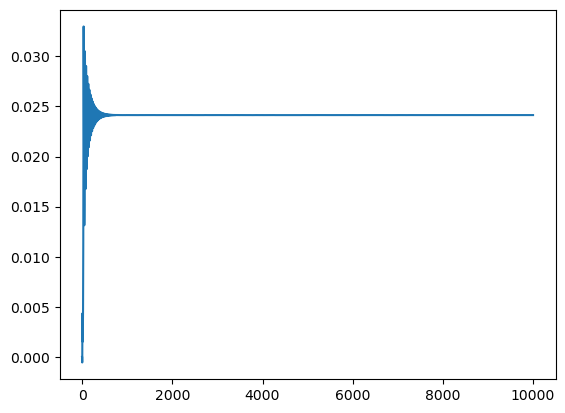

In [ ]:
print(np.cov(bold[80, 4000:]))
plt.plot(time, bold[81, :, None])

In [ ]:
bold[80,:,None].shape

(100001, 1)

In [ ]:
ADNI[:,81]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.,